In [19]:
from plotnine import *
import pandas as pd
import numpy as np

In [20]:
df_detailed = pd.read_csv('../acc_rate_csvs/detailed.csv')
df_detailed = df_detailed[~df_detailed['method'].isin(['BIC.1', 'mmit.1', 'mmit.2', 'mmit.4'])]
df_detailed['dataset'] = ' detailed \n N = 3730'

df_systematic = pd.read_csv('../acc_rate_csvs/systematic.csv')
df_systematic = df_systematic[~df_systematic['method'].isin(['BIC.1', 'mmit.1', 'mmit.2'])]
df_systematic['dataset'] = ' systematic \n N = 3418'

df_epigenomic = pd.read_csv('../acc_rate_csvs/epigenomic.csv')
df_epigenomic = df_epigenomic[~df_epigenomic['method'].isin(['BIC.1', 'mmit.117'])]
df_epigenomic['dataset'] = 'epigenomic \n N = 4913'
df = pd.concat([df_detailed, df_epigenomic, df_systematic, ])

avg_df = df.groupby(['dataset', 'method', 'feature engineer']).agg(
    median_acc=('acc', 'median'),
    q25_acc=('acc', lambda x: np.percentile(x, 25)),
    q75_acc=('acc', lambda x: np.percentile(x, 75))
).reset_index()

In [21]:
acc_compare_df = avg_df.copy()
# acc_compare_df = acc_compare_df[acc_compare_df['method'] != 'BIC.1']
acc_compare_df['lower_bound'] = acc_compare_df['q25_acc']
acc_compare_df['upper_bound'] = acc_compare_df['q75_acc']

In [22]:
acc_compare_df['method'] = pd.Categorical(acc_compare_df['method'], 
                                          categories=['BIC.1', 'mmit.1', 'mmit.2', 'mmit.4', 'mmit.117', 'linear.1', 'linear.2', 'linear.4','linear.117', 'mlp.1', 'mlp.2', 'mlp.4', 'mlp.117'], ordered=True)

In [23]:
max_acc_per_dataset = acc_compare_df.groupby('dataset')['upper_bound'].max().reset_index()
max_acc_per_dataset.loc[:, 'upper_bound'] += 0.5

# Define colors for each method
method_colors = {
    'mmit.1':     'black',
    'linear.1':   'black',
    'mlp.1':      'red',
    'mmit.2':     'black',
    'linear.2':   'black',
    'mlp.2':      'red',
    'mmit.117':   'black',
    'linear.117': 'black',
    'mlp.117':    'red',
    'mmit.4':     'black',
    'linear.4':   'black',
    'mlp.4':      'red'
}

# Define colors for proposed and existing methods
method_colors = {
    ' proposed': 'red',
    'previous  ': 'black'
}

# Create a new column indicating whether the method is proposed or existing
acc_compare_df['category'] = 'previous  '
acc_compare_df.loc[acc_compare_df['method'].str.startswith('mlp'), 'category'] = ' proposed'

In [24]:
acc_compare_df

,dataset,method,feature engineer,median_acc,q25_acc,q75_acc,lower_bound,upper_bound,category
0,detailed \n N = 3730,linear.1,yes,93.420568,93.197958,93.680229,93.197958,93.680229,previous
1,detailed \n N = 3730,linear.117,yes,94.993007,94.279276,95.241095,94.279276,95.241095,previous
2,detailed \n N = 3730,linear.2,yes,94.655034,93.699652,94.930236,93.699652,94.930236,previous
3,detailed \n N = 3730,linear.4,yes,95.150301,94.767854,95.536538,94.767854,95.536538,previous
4,detailed \n N = 3730,mlp.1,yes,93.330078,92.409912,93.479751,92.409912,93.479751,proposed
5,detailed \n N = 3730,mlp.117,no,94.254839,93.568219,95.283497,93.568219,95.283497,proposed
6,detailed \n N = 3730,mlp.2,yes,93.779588,93.310501,94.713884,93.310501,94.713884,proposed
7,detailed \n N = 3730,mlp.4,yes,95.505184,95.110174,95.662656,95.110174,95.662656,proposed
8,detailed \n N = 3730,mmit.117,no,92.638875,92.504404,93.039324,92.504404,93.039324,previous
9,systematic \n N = 3418,linear.1,yes,97.280702,97.057472,97.631579,97.057472,97.631579,previous


In [25]:
plot_combined = (ggplot(acc_compare_df, aes(x='median_acc', y='method', color='category')) +
                 geom_point(shape="D", size=2, fill="white") +
                 geom_errorbarh(aes(xmin='lower_bound', xmax='upper_bound'), height=0.001) +
                 labs(x="accuracy percentage",
                      y="method") +
                 facet_wrap('~dataset', ncol=acc_compare_df['dataset'].nunique(), scales='free_x') +
                 theme_minimal() +
                 theme(aspect_ratio=1.3) +
                 geom_vline(data=max_acc_per_dataset, mapping=aes(xintercept='upper_bound'), color='black') + 
                 scale_color_manual(values=method_colors) +
                 theme(figure_size=(9, 4),
                       axis_text=element_text(size=14),
                       axis_title=element_text(size=14),
                       legend_title=element_text(size=14),
                       legend_text=element_text(size=14),
                       strip_text=element_text(size=14)) +   # Adjusts the facet labels' font size
                 guides(color=guide_legend(title="method"))  # Manual legend
                 )

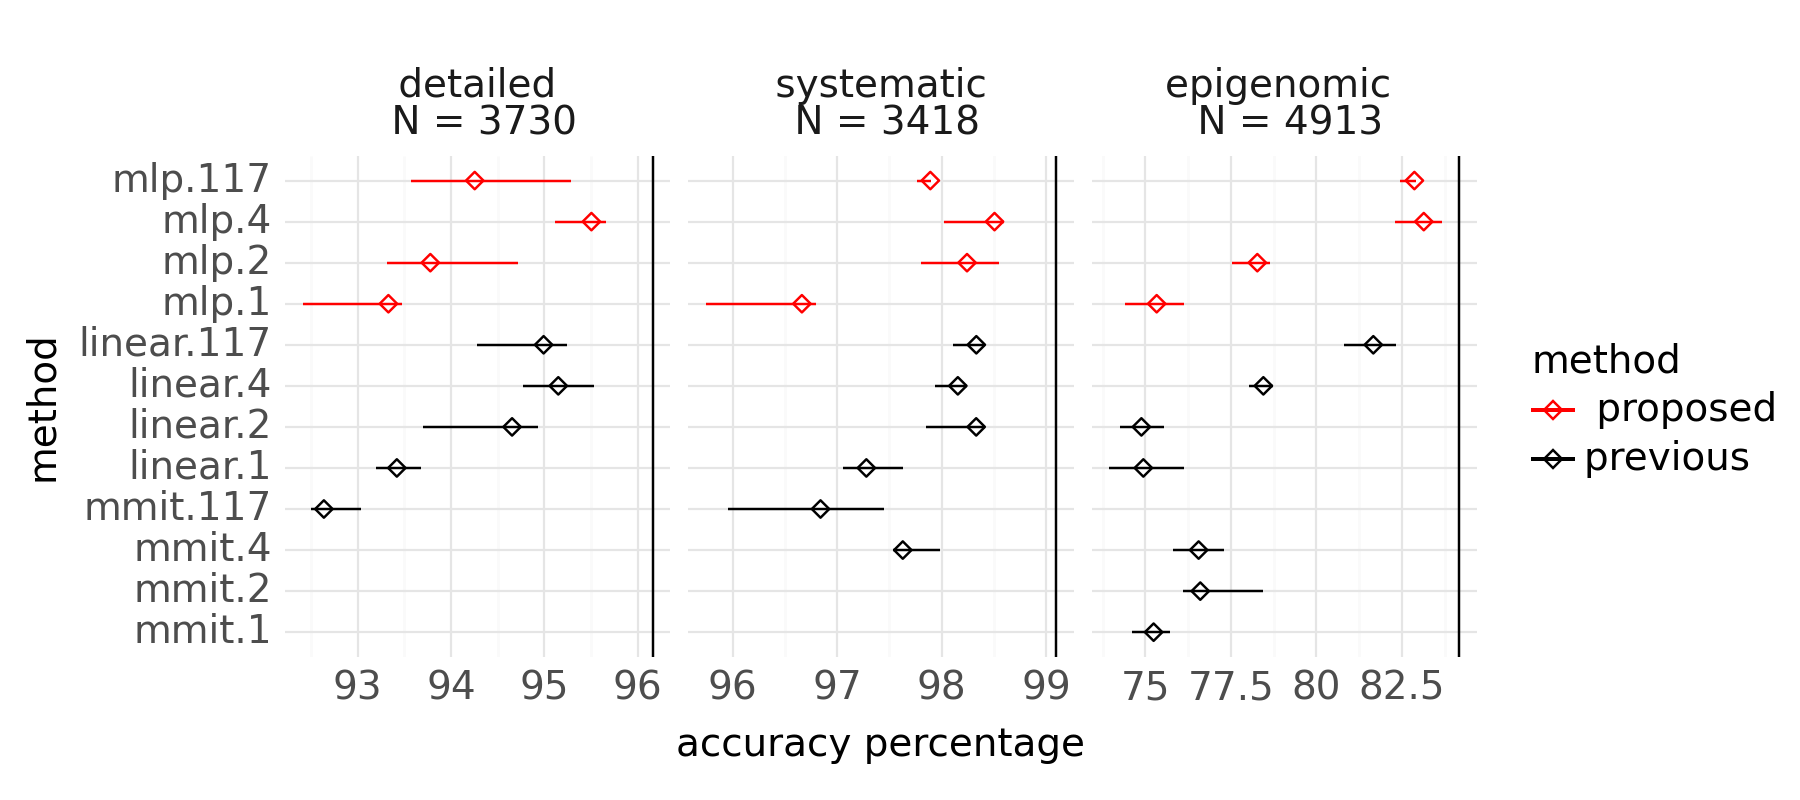

<Figure Size: (900 x 400)>

In [26]:
plot_combined

In [27]:
plot_combined.save("acc_compare.pdf")
plot_combined.save("acc_compare.jpg")

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 9 x 4 in image.
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: acc_compare.pdf
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 9 x 4 in image.
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: acc_compare.jpg
